In [1]:
import os
from copy import deepcopy
import math
import natsort
import random
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from umap import UMAP
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils.data import TensorDataset, Dataset, DataLoader

from torchNDF.metrics import *
from torchNDF.models.recurrent_wrapper import *
from torchNDF.data.torch_utils import *
from torchNDF.data.datahandler import FXDataHandler
from torchNDF.vis import *

## In this notebook:

* Static training and evaluation
* Rolling training and evaluation
* Trade activity plot and performance comparison
* Explainability plots: input gradients and UMAP

In [2]:
CURR_IDX = 1
TECH_START_IDX = 65
LABEL_START_IDX = 1123
CURRENCIES = ['USDCNY', 'USDIDR', 'USDINR', 'USDKRW', 'USDPHP', 'USDTWD']
CURR_N = CURRENCIES[CURR_IDX]

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Data prep:

In [4]:
PATH = Path('../../data/final').resolve()
input_data = pd.read_pickle(f'{PATH}/input_data_labels')
returns = pd.read_pickle(f'{PATH}/returns')
expert_oracle_labels = pd.read_pickle(f'{PATH}/expert_oracle_labels')

In [5]:
data, expert_labels = input_data.iloc[:, :LABEL_START_IDX], input_data.iloc[:, LABEL_START_IDX:]
dh = FXDataHandler()
dh.assign_data(data)
dh.split_train_val_test([60, 30, 10])
dh.to_tensor(device=device)
train, val, test = dh.datasets

len_slice = 30
bs = 32

trainloader = DataLoader(RegularFinancialData(train, len_slice),
                         batch_size=bs, shuffle=True)


valloader = DataLoader(RegularFinancialData(val, len_slice), 
                       batch_size=len(val), shuffle=False)

In [6]:
# split returns into train, val, test returns
len(train), len(val), len(test)

(892, 446, 148)

In [7]:
# returns from last day for sequence of length `len_slice`
train_returns = returns[:, len_slice:len(train)+len_slice, :]

val_returns = returns[:, len_slice+len(train): \
                 len(train)+len(val), :]

test_returns = returns[:, len_slice+len(train)+len(val): \
                  len(train)+len(val)+len(test), :]

## Static Validation

In [8]:
train_returns_single = torch.Tensor(train_returns[:, :, CURR_IDX]).to(device)
val_returns_single = torch.Tensor(val_returns[:, :, CURR_IDX]).to(device)

ensemble_size=1
ensemble = []

# seeds
seed_list = []
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

for _ in range(ensemble_size):
    torch.manual_seed(_)
    np.random.seed(_)
    torch.cuda.manual_seed_all(_)
    seed_list.append((_, _, _))
    
    m = RecurrentWrapper(seq_len = len_slice,
                         rec_cell_type='GRU',
                         in_dim=1123,
                         latent_dim=512, 
                         n_recurrent_layers=2,
                         mlp_in_dim=512, 
                         mlp_out_dim=91, 
                         mlp_layers=[128],
                         dropout_prob=0.2,
                        ).to(device)
    
    opt = torch.optim.Adam(m.parameters(), lr=0.006, weight_decay=0.0003)
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, 200, eta_min=0.003, T_mult=2)
    m.fit(epochs=200, 
          trainloader=trainloader, 
          valloader=valloader, 
          opt=opt, 
          sched=sched, 
          device=device, 
          log_interval=1000, 
          dropout_schedule=[0.2, 0.2, 0., 0.], 
          dropout_interval=50,
          tr_returns=train_returns_single,
          val_returns=val_returns_single
          )
    
    ensemble.append(m)

Epoch: 0
Training Loss: 4.53
Avg train returns: 0.1
Avg train optimal returns: 1.19 

Validation Loss: 4.72
Validation Accuracy: 1.68
Avg val returns: 2.61
Avg val optimal returns: 12.6 

Epoch: 1
Training Loss: 4.23
Avg train returns: 0.81
Avg train optimal returns: 1.36 

Validation Loss: 7.48
Validation Accuracy: 4.57
Avg val returns: 2.5
Avg val optimal returns: 12.6 

Epoch: 2
Training Loss: 3.73
Avg train returns: 0.56
Avg train optimal returns: 1.3 

Validation Loss: 8.67
Validation Accuracy: 3.12
Avg val returns: 1.12
Avg val optimal returns: 12.6 

Epoch: 3
Training Loss: 3.76
Avg train returns: 0.59
Avg train optimal returns: 1.37 

Validation Loss: 11.68
Validation Accuracy: 3.37
Avg val returns: 1.31
Avg val optimal returns: 12.6 

Epoch: 4
Training Loss: 3.71
Avg train returns: 0.7
Avg train optimal returns: 1.27 

Validation Loss: 8.67
Validation Accuracy: 2.4
Avg val returns: 0.56
Avg val optimal returns: 12.6 

Epoch: 5
Training Loss: 3.67
Avg train returns: 0.81
Avg tr

Epoch: 44
Training Loss: 2.87
Avg train returns: 0.9
Avg train optimal returns: 1.21 

Validation Loss: 22.62
Validation Accuracy: 0.48
Avg val returns: -0.14
Avg val optimal returns: 12.6 

Epoch: 45
Training Loss: 3.03
Avg train returns: 0.92
Avg train optimal returns: 1.24 

Validation Loss: 14.26
Validation Accuracy: 0.24
Avg val returns: 1.58
Avg val optimal returns: 12.6 

Epoch: 46
Training Loss: 2.66
Avg train returns: 0.9
Avg train optimal returns: 1.13 

Validation Loss: 15.87
Validation Accuracy: 1.2
Avg val returns: 1.43
Avg val optimal returns: 12.6 

Epoch: 47
Training Loss: 2.91
Avg train returns: 0.96
Avg train optimal returns: 1.29 

Validation Loss: 19.47
Validation Accuracy: 0.72
Avg val returns: 0.74
Avg val optimal returns: 12.6 

Epoch: 48
Training Loss: 3.06
Avg train returns: 0.77
Avg train optimal returns: 1.07 

Validation Loss: 20.71
Validation Accuracy: 0.48
Avg val returns: 1.87
Avg val optimal returns: 12.6 

Epoch: 49
Training Loss: 2.83
Avg train returns

Epoch: 88
Training Loss: 2.56
Avg train returns: 0.95
Avg train optimal returns: 1.2 

Validation Loss: 18.8
Validation Accuracy: 0.24
Avg val returns: 0.47
Avg val optimal returns: 12.6 

Epoch: 89
Training Loss: 2.75
Avg train returns: 1.15
Avg train optimal returns: 1.51 

Validation Loss: 22.04
Validation Accuracy: 0.48
Avg val returns: 0.13
Avg val optimal returns: 12.6 

Epoch: 90
Training Loss: 2.36
Avg train returns: 0.9
Avg train optimal returns: 1.2 

Validation Loss: 17.32
Validation Accuracy: 0.48
Avg val returns: 0.12
Avg val optimal returns: 12.6 

Epoch: 91
Training Loss: 2.53
Avg train returns: 1.26
Avg train optimal returns: 1.49 

Validation Loss: 20.51
Validation Accuracy: 0.24
Avg val returns: 0.04
Avg val optimal returns: 12.6 

Epoch: 92
Training Loss: 2.71
Avg train returns: 1.1
Avg train optimal returns: 1.49 

Validation Loss: 23.3
Validation Accuracy: 0.0
Avg val returns: -0.03
Avg val optimal returns: 12.6 

Epoch: 93
Training Loss: 2.4
Avg train returns: 1.2

Epoch: 131
Training Loss: 2.23
Avg train returns: 1.01
Avg train optimal returns: 1.22 

Validation Loss: 38.99
Validation Accuracy: 0.24
Avg val returns: 0.47
Avg val optimal returns: 12.6 

Epoch: 132
Training Loss: 2.38
Avg train returns: 1.24
Avg train optimal returns: 1.48 

Validation Loss: 35.57
Validation Accuracy: 0.96
Avg val returns: 0.6
Avg val optimal returns: 12.6 

Epoch: 133
Training Loss: 2.23
Avg train returns: 1.07
Avg train optimal returns: 1.37 

Validation Loss: 41.87
Validation Accuracy: 0.72
Avg val returns: 0.46
Avg val optimal returns: 12.6 

Epoch: 134
Training Loss: 2.65
Avg train returns: 0.83
Avg train optimal returns: 1.14 

Validation Loss: 31.89
Validation Accuracy: 0.48
Avg val returns: 1.56
Avg val optimal returns: 12.6 

Epoch: 135
Training Loss: 2.35
Avg train returns: 0.95
Avg train optimal returns: 1.26 

Validation Loss: 38.69
Validation Accuracy: 0.48
Avg val returns: 0.73
Avg val optimal returns: 12.6 

Epoch: 136
Training Loss: 2.35
Avg train 

## Rolling Validation

* Rolling validation is performed on the same trading days comprising the static validation set in order to evaluate the difference in performance between the two training methods

In [91]:
static_train_l = len(train)
static_val_l = len(val)

In [92]:
PATH = Path('../../data/final').resolve()
input_data = pd.read_pickle(f'{PATH}/input_data_labels')
returns = pd.read_pickle(f'{PATH}/returns')
expert_oracle_labels = pd.read_pickle(f'{PATH}/expert_oracle_labels')



len_slice = 30
bs = 32
chunk_size = 800
stride_length = 1

# use static validation training and val set dimensions to calculate
# start and end day index of rolling validation procedure
# NOTE: final `+ len_slice` is required to match static validation number of 
START_IDX = static_train_l - (chunk_size + 91) + len_slice  

# trading days 
END_IDX = static_train_l + static_val_l - (chunk_size + 91)   
n_rolling_runs = (END_IDX - START_IDX)//stride_length

# split labels from data 
data, expert_labels = input_data.iloc[:, :LABEL_START_IDX], input_data.iloc[:, LABEL_START_IDX:]

In [ ]:
# to store ROI and acc
rets, mod_acc, mod_oacc, retse, retseo, retsop = [], [], [], [], [], []

for run in range(3):
    for j in range(n_rolling_runs):
        # data for specific rolling run: chunk of 360 + 91 days
        # 360 are used for training and the single point at 360 + 91 for out-of-sample
        # validation
        run_data = data[j*stride_length : START_IDX + j*stride_length + chunk_size + 91]
        run_returns = torch.Tensor(returns[:, START_IDX + j*stride_length : \
                                           START_IDX + j*stride_length + chunk_size + 91, CURR_IDX]).to(device)

        dh = FXDataHandler()
        dh.assign_data(run_data)
        # split done manually 
        dh.split_train_val_test([100, 0, 0])
        dh.to_tensor(device=device)
        tensor_data, _, _ = dh.datasets


        train = tensor_data[:chunk_size]
        # val contains a single slice of len `len_slice` which ends
        # with trading day 360 + 91
        val = tensor_data[-len_slice:]
        train_returns = run_returns[:, len_slice:len(train)+len_slice]
        # 0-indexing: 91 -> 90
        val_returns = run_returns[:, len(train)+90]

        expo = expert_oracle_labels[CURR_IDX][[START_IDX + j*stride_length + chunk_size + 90]]
        # exp from labels
        exp = expert_labels.values[START_IDX + j*stride_length + chunk_size + 90, CURR_IDX]

        trainloader = DataLoader(RegularFinancialData(train, len_slice),
                                 batch_size=bs, shuffle=True)


        #valloader = DataLoader(RegularFinancialData(val, len_slice), 
        #                       batch_size=len(val), shuffle=False)


        ensemble_size=1
        ensemble = []
        # seeds
        seed_list = []
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        print(f'***** Processing slice: {j} ***** \n')
        
        for _ in range(ensemble_size):
            torch.manual_seed(_)
            np.random.seed(_)
            torch.cuda.manual_seed_all(_)
            seed_list.append((_, _, _))
            
            m = RecurrentWrapper(seq_len = len_slice,
                                 rec_cell_type='LSTM',
                                 in_dim=1132,
                                 latent_dim=512, 
                                 n_recurrent_layers=2,
                                 mlp_in_dim=512, 
                                 mlp_out_dim=91, 
                                 mlp_layers=[128],
                                 dropout_prob=0.2,
                                ).to(device)
            
            opt = torch.optim.Adam(m.parameters(), lr=0.006, weight_decay=0.0003)
            sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, 200, eta_min=0.003, T_mult=2)
            m.fit(epochs=10, 
                  trainloader=trainloader, 
                  valloader=None, 
                  opt=opt, 
                  sched=sched, 
                  device=device, 
                  log_interval=5000, 
                  dropout_schedule=[0.2, 0.2, 0., 0.], 
                  dropout_interval=50,
                  tr_returns=train_returns,
                  val_returns=val_returns,
                  )

            m.eval()
            m.MLP.drop_probability = 0.
            m.recurrent_layers.drop_probability = 0.
            ensemble.append(m)

        

        # make batch of size 1 with unsqueeze
        val = val.unsqueeze(0)
        val = val[:, :-1]
        _, optimal_act = val_returns.max(0)
        for i in range(ensemble_size):
            prediction = ensemble_predictions(ensemble=[ensemble[i]], data=val, device=device)
            retmod = val_returns[prediction]

            acc_opt = (prediction.to(device) == optimal_act)
            acc_pos = retmod >= 0
            mod_oacc.append(acc_opt)
            mod_acc.append(acc_pos)
            
            retexp = val_returns[exp]
            retexpo = val_returns[expo]
            retsopt, _ = val_returns.max(0)
            rets.append(retmod.item())
            retse.append(retexp.item())
            retseo.append(retexpo.item())
            retsop.append(retsopt.item())

## Actions visualization and performance metrics

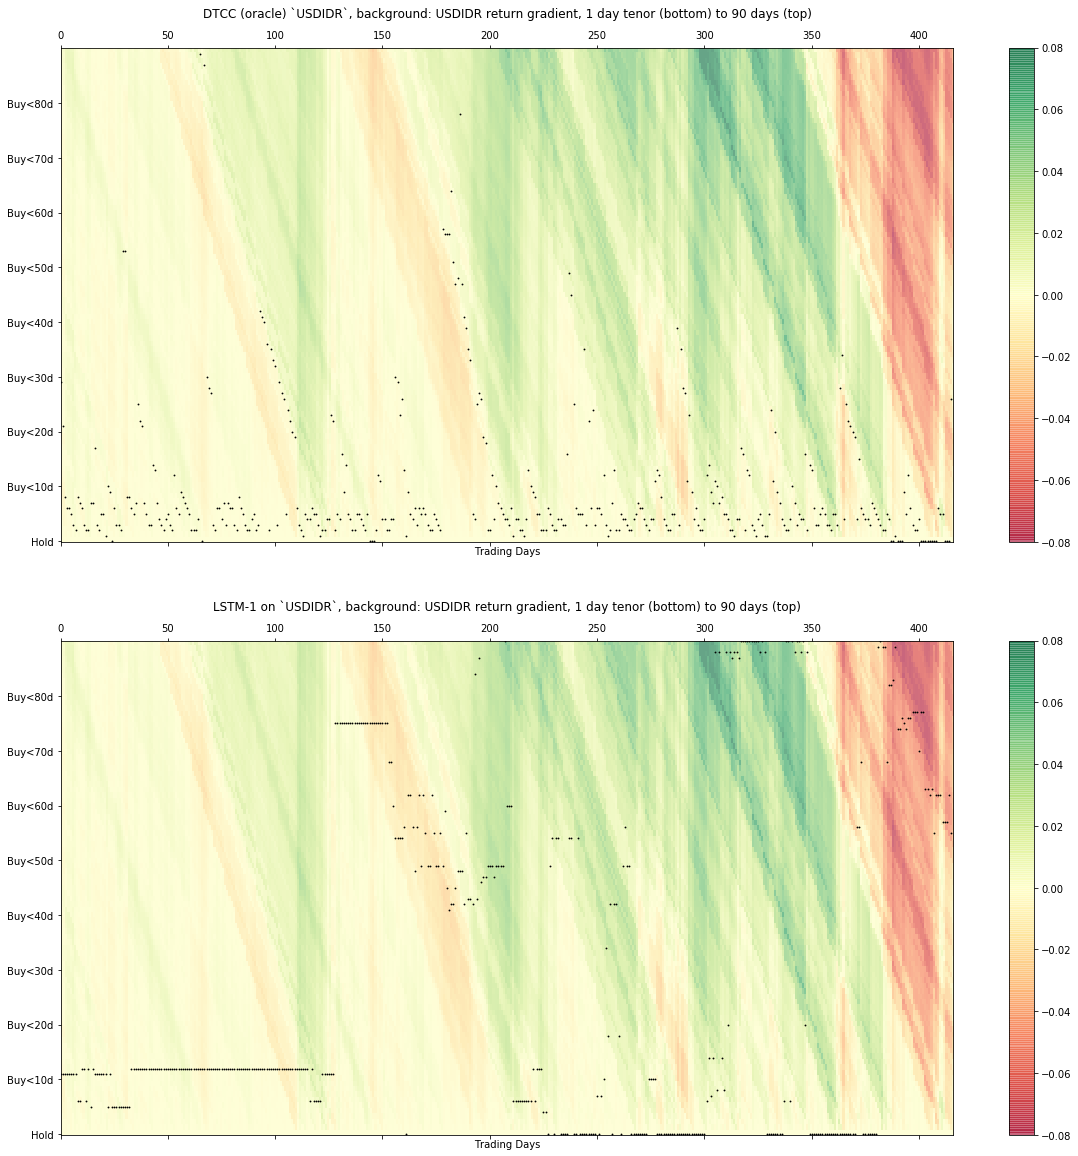

In [26]:
# remove dropout
for model in ensemble:
    model.eval()
    model.MLP.drop_probability = 0.
    model.recurrent_layers.drop_probability = 0.
    
# name from input_data columns

# exp oracle from separate oracle np.array
expo = expert_oracle_labels[CURR_IDX][len(train)+len_slice:len(train)+len(val)]
# exp from labels
exp = expert_labels.values[len(train)+len_slice:len(train)+len(val), CURR_IDX]
# validation returns for single currency, first `len_slice` days are removed to match predictions
valr = val_returns[:, :, CURR_IDX]
data, _ = next(iter(valloader))
data = data[:, :-1, :]
predictions = ensemble_predictions(ensemble=[ensemble[0]], data=data, device=device, mode='mode')

plot_activity(predictions, model_name='LSTM-1', curr_name=CURR_N, expert_labels=expo, returns=valr)

### UMAP of latents

In [27]:
# hook the latents out of the first post conv MLP layer
model = ensemble[0].to(device)

latents = []
pred_ensemble = []
iterator = iter(valloader)

data, _ = next(iterator)
data_clip = data[:,:-1,:]
h = Hook(model._modules['recurrent_layers']) 
yhat = model(data_clip)
probs = nn.Softmax(1)(yhat)  
_, predictions = torch.max(probs, 1)
latents = h.output[0][-1]

In [28]:
# compute action indices for different baselines
opt_idxs = []
exp_idxs = []
mod_idxs = []
opt_actions = valr.argmax(0)
for i in range(91):
    opt_idxs.append((opt_actions==i).nonzero()[0])
    exp_idxs.append((expo==i).nonzero()[0])
    mod_idxs.append((predictions==i).nonzero().cpu())
for i in range(91): 
    opt_idxs[i] = np.array(opt_idxs[i].flatten())
    exp_idxs[i] = np.array(exp_idxs[i].flatten())
    mod_idxs[i] = np.array(mod_idxs[i].flatten())

pca = UMAP(n_components=3)
emb = pca.fit_transform(latents.detach().cpu().numpy())

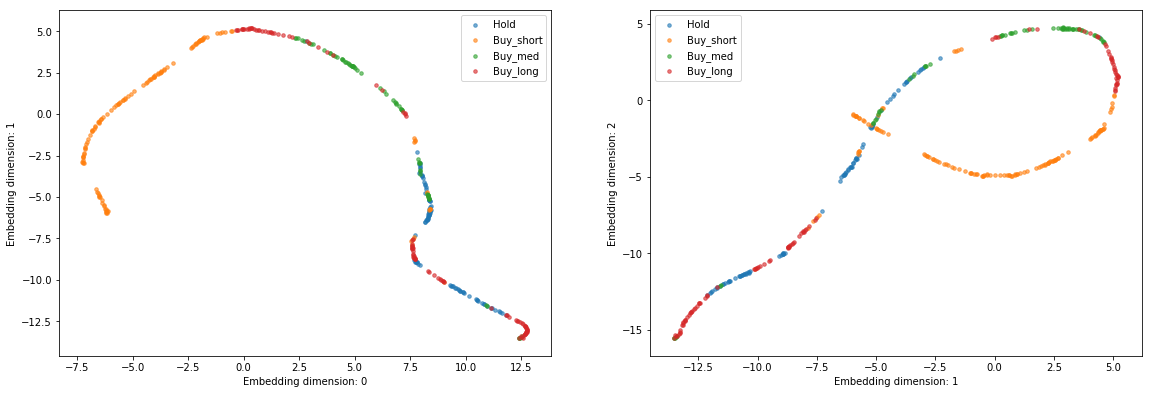

In [29]:
plot_trade_mode_embeddings(emb, mod_idxs, dims_to_plot=2)
#plt.savefig(f'{curr_n}, trade_behavior_PCA.jpg', dpi=200)

## Effectiveness: ROI and additional metrics

In [30]:
predictions = predictions.cpu()
valr = torch.Tensor(valr)
# expert actions
texp = torch.Tensor(exp).to(dtype=torch.long)
# expert oracle
texpo = torch.Tensor(expo).to(dtype=torch.long)
# optimal
_, topt = valr.max(0)
topt = topt.to(dtype=torch.long)
# last_seen (Momentum)
ls_exp = texp
ls_exp[1:] = ls_exp[0:-1]
ls_exp[0] = 0


modelContainer = returns_and_activity(returns=valr, predictions=predictions, baseline=None, input_data=data)
expertContainer = returns_and_activity(returns=valr, predictions=texpo, baseline='expert', input_data=data)
oracleContainer = returns_and_activity(returns=valr, predictions=texpo, baseline='expert', input_data=data)
optimalContainer = returns_and_activity(returns=valr, predictions=topt, baseline='expert', input_data=data)
momentumContainer = returns_and_activity(returns=valr, predictions=ls_exp, baseline='expert', input_data=data)
randomContainer = returns_and_activity(returns=valr, predictions=None, baseline='random', input_data=data)

In [33]:
modelContainer

Returns 0.31
Standard dev of returns 0.0223
Cumulative sum of tenors 12677
Number of Buys 328
Positive return accuracy 63.7
Optimal return accuracy 0.72

## Explainability plots

In [626]:
data, _ = next(iter(valloader))
y = torch.Tensor(optimal_quantized_action).to(dtype=torch.long).to(device)
x = deepcopy(data[:, :-1, :-1]).to(device)
x.requires_grad = True
probs = ensemble[0](x)
preds = nn.Softmax(1)(probs)
loss = nn.CrossEntropyLoss()(preds, y)
loss.backward()

In [627]:
def plot_input_gradients(gradients:torch.Tensor, mode:str='mat', rows_to_plot:int=10, col_features:list=None,
                        background:np.array=None):
    if mode=='mat':
        fig, ax = plt.subplots(figsize=(15, 18))
        im = ax.matshow(gradients.mean(0).cpu().numpy(), cmap='Greys', alpha=0.9, aspect='auto')
        fig.colorbar(im)
        ax.set_ylabel('day index (higher more recent)')
        ax.set_xlabel('features')
        plt.title('Input gradients of input features: classification labels of previous days')
    elif mode=='bar':
        plt.figure(figsize=(22,200))
        for i in range(rows_to_plot):
            plt.subplot(70,1,1+i)
            slice_gradients = abs(gradients[:, :, 10*i:10*(i+1)].mean(0).mean(0).cpu().numpy())
            m = gradients.max()
            plt.bar(np.arange(0, 10), slice_gradients, width=0.4, \
                    alpha=0.7, edgecolor='black')    
            plt.xticks(np.arange(0, 10), col_features[10*i:10*(i+1)])
            if background:
                plt.pcolor(np.arange(-0.5, 10.5), [0, m], abs(background[10*i:10*(i+1)]).values[np.newaxis], alpha=0.3, cmap='Greens')
                plt.colorbar()  

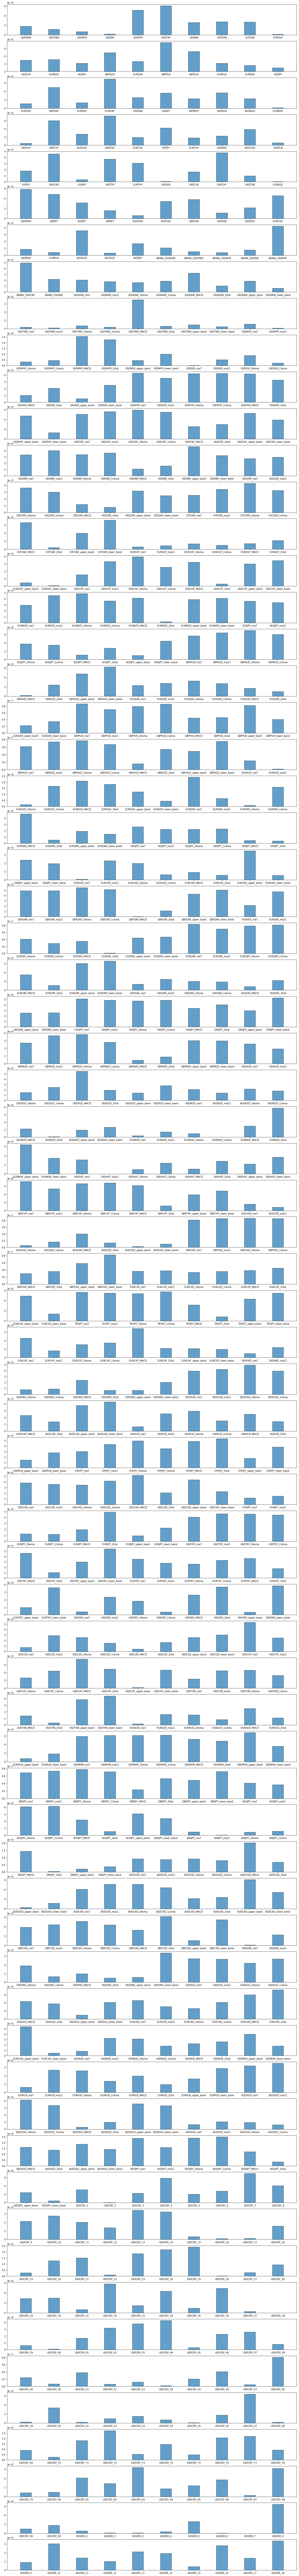

In [87]:
plot_input_gradients(gradients=x.grad, mode='bar', rows_to_plot=70, col_features=input_data.columns)

#### Input gradients for single class of tenors

Here we analyze the input gradients for a single tenor label (e.g `90`)

In [262]:
spots = input_data.iloc[:, :TECH_START_IDX]
volatility = spots.rolling(20).std()
val_spots = spots[len(train):]
volatility = volatility[len(train):]
correlations = spots.corr()[CURR_N]

In [230]:
data, _ = next(iter(valloader))
y = torch.Tensor(optimal_quantized_action).to(dtype=torch.long).to(device)
x = deepcopy(data[:, :-1, :-1]).to(device)
# indices of interest to plot slices of spot
req_idxs = (y==90).nonzero().flatten()
# val data for specific action
partial_y = y[y==90]
partial_x = x[y==90]
partial_x.requires_grad = True
probs = ensemble[0](partial_x)
preds = nn.Softmax(1)(probs)
loss = nn.CrossEntropyLoss()(preds, partial_y)
loss.backward()

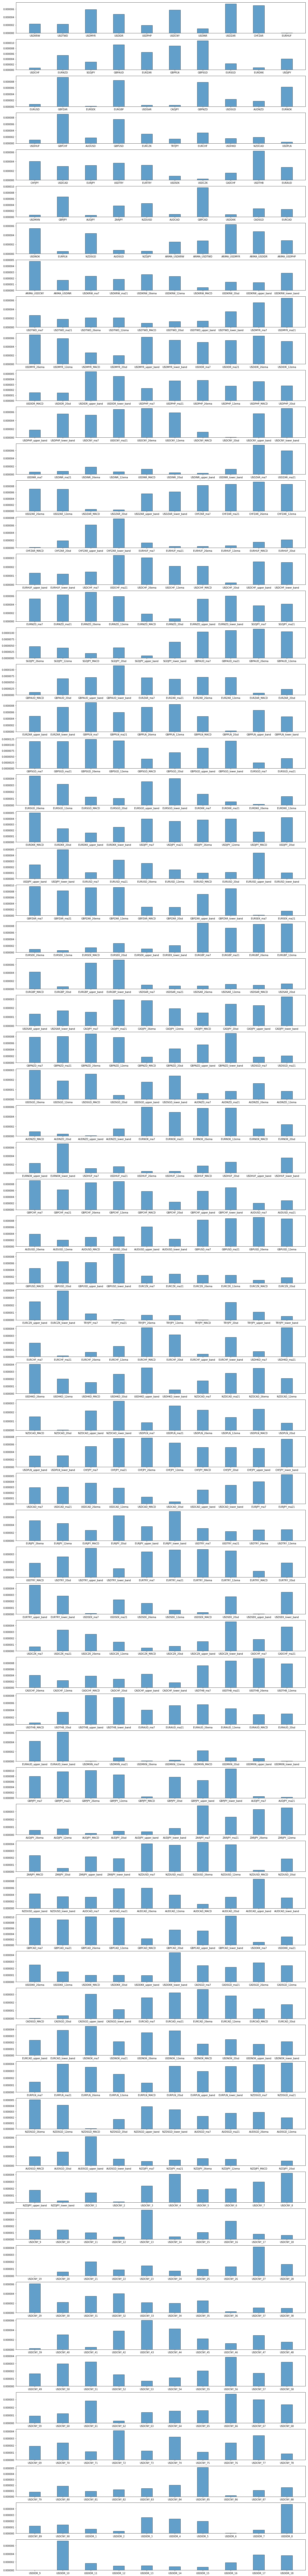

In [257]:
plot_input_gradients(gradients=partial_x.grad, mode='bar', rows_to_plot=70, col_features=input_data.columns)

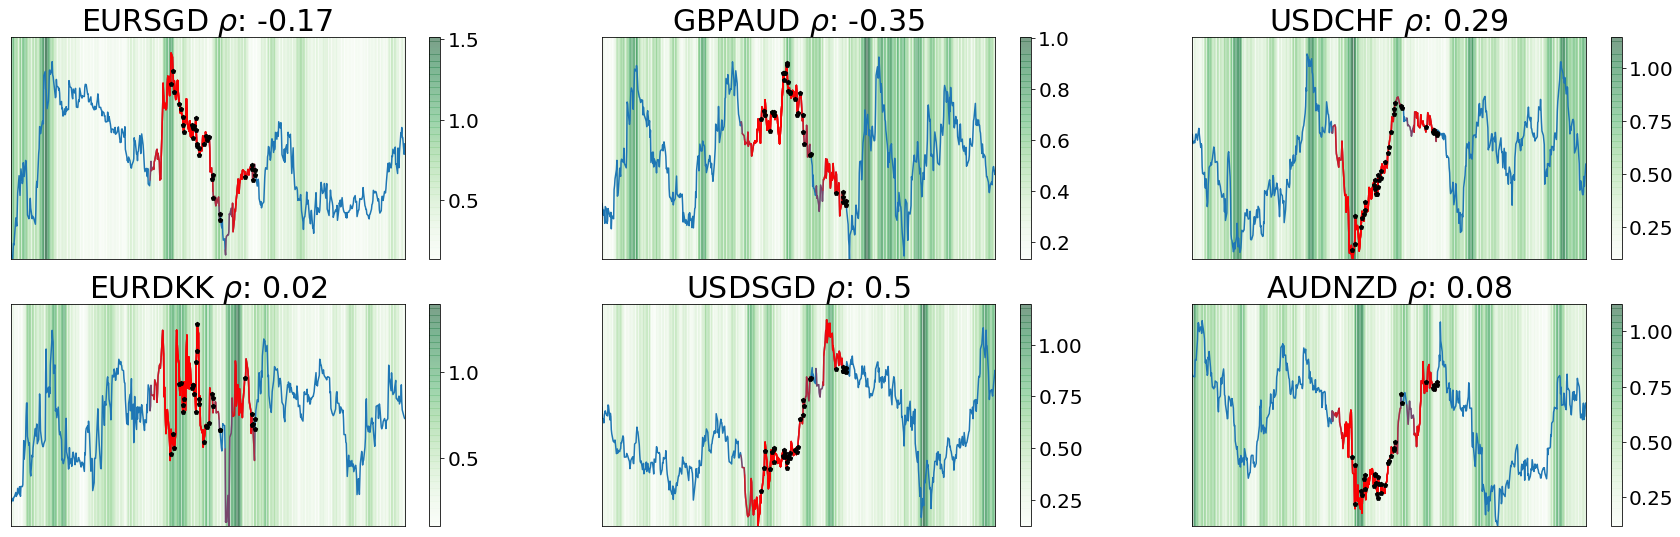

In [491]:
plot_explaining_currency(partial_x.grad, req_idxs, val_spots, volatility, 'abs', 6)
plt.savefig('input_grads.pdf')